In [1]:
import keras
import pandas as pd
import os
import cv2
import scipy
from keras.callbacks import ModelCheckpoint
from keras.utils.vis_utils import plot_model


import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
import pickle

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Activation, Dense, Conv2D, Reshape, concatenate, BatchNormalization, MaxPooling2D, GlobalAveragePooling2D
from keras.models import Model
from keras.callbacks import LearningRateScheduler
from keras import optimizers
from IPython.display import clear_output
%matplotlib inline
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from random import randint
from sklearn.utils import shuffle


In [3]:
IMG_SIZE = 128

In [4]:
#to read data in for pickle to be used for python
pickle_in = open(r"C:\Users\arifm\OneDrive\Documents\PRJ400\blood cells\Data\X_train.pickle", "rb")
X_train = pickle.load(pickle_in)

pickle_in = open(r"C:\Users\arifm\OneDrive\Documents\PRJ400\blood cells\Data\y_train.pickle", "rb")
y_train = pickle.load(pickle_in)

pickle_in = open(r"C:\Users\arifm\OneDrive\Documents\PRJ400\blood cells\Data\X_test.pickle", "rb")
X_test = pickle.load(pickle_in)

pickle_in = open(r"C:\Users\arifm\OneDrive\Documents\PRJ400\blood cells\Data\y_test.pickle", "rb")
y_test = pickle.load(pickle_in)

In [5]:
X_train = np.array(X_train)
X_test = np.array(X_test)

X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

In [6]:
y_train = np.array(y_train)
y_test = np.array(y_test)

In [7]:
print(len(X_train),len(y_train))
print(X_train[10].shape)
print(y_train.shape)

9957 9957
(128, 128, 3)
(9957,)


In [8]:
def lr_decay(epoch):
  return 0.01 * math.pow(0.666, epoch)

callback_learning_rate = LearningRateScheduler(lr_decay, verbose=True)

callback_is_nan = tf.keras.callbacks.TerminateOnNaN()

class PlotLosses(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.legend()
        plt.show();
        
plot_losses = PlotLosses()


In [9]:
bnmomemtum=0.85
def fire(x, squeeze, expand):
  y  = Conv2D(filters=squeeze, kernel_size=1, activation='relu', padding='same')(x)
  y  = BatchNormalization(momentum=bnmomemtum)(y)
  y1 = Conv2D(filters=expand//2, kernel_size=1, activation='relu', padding='same')(y)
  y1 = BatchNormalization(momentum=bnmomemtum)(y1)
  y3 = Conv2D(filters=expand//2, kernel_size=3, activation='relu', padding='same')(y)
  y3 = BatchNormalization(momentum=bnmomemtum)(y3)
  return concatenate([y1, y3])

def fire_module(squeeze, expand):
  return lambda x: fire(x, squeeze, expand)

x = Input(shape=[IMG_SIZE, IMG_SIZE, 3])
y = BatchNormalization(center=True, scale=False)(x)
y = Activation('relu')(y)
y = Conv2D(kernel_size=5, filters=12, padding='same', use_bias=True, activation='relu')(x)
y = BatchNormalization(momentum=bnmomemtum)(y)

y = fire_module(12, 24)(y)
y = MaxPooling2D(pool_size=2)(y)

y = fire_module(24, 48)(y)
y = MaxPooling2D(pool_size=2)(y)

y = fire_module(32, 64)(y)
y = MaxPooling2D(pool_size=2)(y)

y = fire_module(24, 48)(y)
y = MaxPooling2D(pool_size=2)(y)

y = fire_module(18, 36)(y)
y = MaxPooling2D(pool_size=2)(y)

y = fire_module(12, 24)(y)

y = GlobalAveragePooling2D()(y)
y = Dense(4, activation='sigmoid')(y)
model = Model(x, y)
model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 12) 912         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 128, 128, 12) 48          conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 128, 128, 12) 156         batch_normalization_2[0][0]      
____________________________________________________________________________________________

In [11]:
filepath = r"C:\Users\arifm\OneDrive\Documents\PRJ400\blood cells\weight_tr5.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]
history = model.fit(X_train,
         y_train,
         epochs = 3,
         batch_size = 32,
         validation_split=0.25,
         shuffle=True,
         callbacks = callbacks_list,
         verbose = 1)

Train on 7467 samples, validate on 2490 samples
Epoch 1/3
7467/7467 [==============================] - 187s 25ms/step - loss: 0.5483 - accuracy: 0.8886 - val_loss: 0.5710 - val_accuracy: 0.8574
Epoch 2/3


C:\Users\arifm\Anaconda3\envs\tf-gpu\lib\site-packages\keras\callbacks\callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


7467/7467 [==============================] - 175s 23ms/step - loss: 0.5359 - accuracy: 0.8935 - val_loss: 0.6332 - val_accuracy: 0.8289
Epoch 3/3
7467/7467 [==============================] - 176s 24ms/step - loss: 0.5243 - accuracy: 0.8958 - val_loss: 0.5352 - val_accuracy: 0.8482


In [12]:
model.save('third1_model.h5')
model.save_weights('thrid_weight_model.h5')

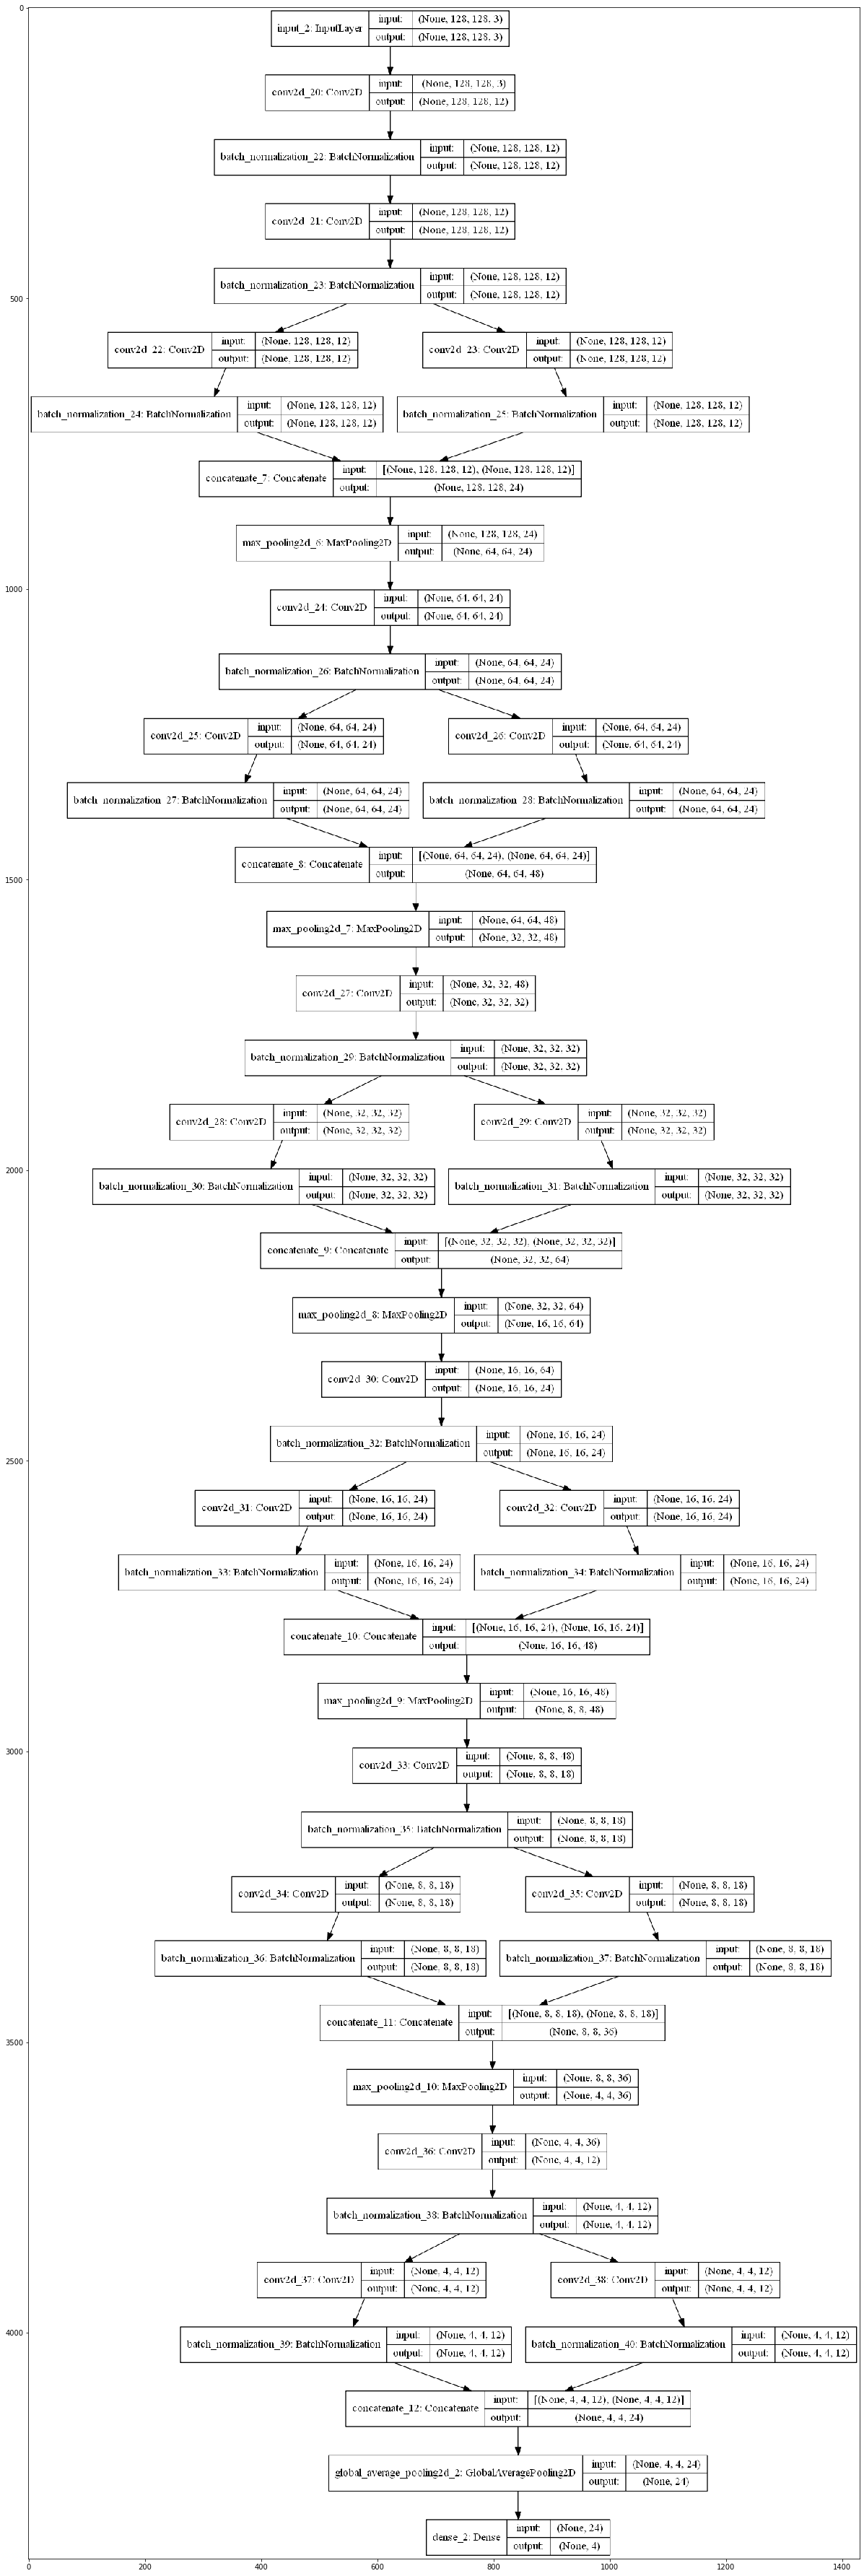

In [14]:
import pydot
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
plt.figure(figsize=(65,65))
plt.imshow(plt.imread('model_plot.png'))

In [10]:
# Recreate the exact same model, including its weights and the optimizer
model.load_weights('thrid_weight_model.h5')

#load save model

In [11]:
#evaluate model once loaded in
loss, acc = model.evaluate(X_test,  y_test, verbose=2)
print('Restored model, accuracy: {:5.2f}%'.format(100*acc))

Restored model, accuracy: 69.04%


In [9]:
def check_pydot():
  """Returns True if PyDot and Graphviz are available."""
  if pydot is None:
    return False
  try:
    # Attempt to create an image of a blank graph
    # to check the pydot/graphviz installation.
    pydot.Dot.create(pydot.Dot())
    return True
  except OSError:
    return False

In [21]:
check_pydot()

True

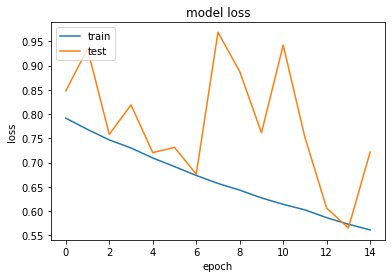

In [15]:
def plot_learning_curve(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./accuracy_curve1.png')
    plt.clf()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./loss_curve1.png')

plot_learning_curve(history)

In [20]:
accuracy = history.history['accuracy']
loss = history.history['loss']
val_accuracy = history.history['val_accuracy']
val_loss = history.history['val_loss']

print(f'Training Accuracy: {np.max(accuracy)}')
print(f'Training Loss: {np.min(loss)}')
print(f'Validation Accuracy: {np.max(val_accuracy)}')
print(f'Validation Loss: {np.min(val_loss)}')

Training Accuracy: 0.8885122537612915
Training Loss: 0.5614599674659485
Validation Accuracy: 0.8634538054466248
Validation Loss: 0.565403482042642


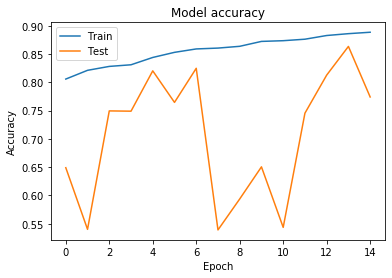

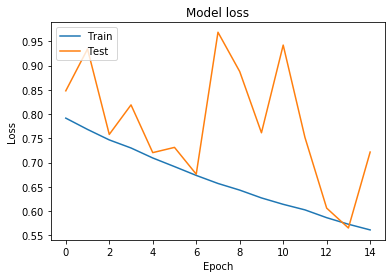

In [21]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [22]:
pred_dataset_path = r"C:\Users\arifm\OneDrive\Documents\PRJ400\blood cells\blood-cells\dataset2-master\dataset2-master\images\TEST_SIMPLE"

IMG_SIZE      = 128
#data_list     = os.listdir(train_dataset_path)
#NUM_CLASSES   = len(data_list)


In [51]:
CATEGORIES    = ['NEUTROPHIL', 'EOSINOPHIL','MONOCYTE','LYMPHOCYTE']

In [23]:
def get_images(directory):
    Images = []
    for categories in CATEGORIES:
        all_image_paths=os.listdir(pred_dataset_path+'/'+categories)
        for image_file in all_image_paths:
            image=cv2.imread(directory+'/'+categories+'/'+image_file)
            image=cv2.resize(image,(IMG_SIZE, IMG_SIZE))
            Images.append(image)

    return shuffle(Images,random_state=81732)

pred_images = get_images(pred_dataset_path)
pred_images = np.array(pred_images)
pred_images.shape

(71, 128, 128, 3)

In [94]:
#making this predictions
prediction_single = model.predict(X_test)
print(np.argmax(prediction_single[0]))
#getting the max value of the prection



0


In [95]:
pred_results = []
for i in range(len(prediction_single)):
    result = np.argmax(prediction_single[i])
    pred_results.append(result)
    print(result,y_test[i])

0 0
3 3
1 1
0 0
2 2
1 1
2 2
3 3
1 1
1 1
0 0
1 1
1 2
0 0
1 3
3 3
2 2
3 3
0 0
0 1
1 1
0 2
3 3
3 3
0 0
2 2
3 3
2 2
0 0
3 1
3 3
2 2
0 2
1 2
3 3
0 2
1 1
0 0
3 3
1 1
1 2
1 0
3 3
0 0
0 0
0 0
3 3
3 3
3 3
1 1
1 1
1 1
1 0
3 3
1 1
0 0
3 3
2 2
1 2
1 2
0 2
1 1
1 1
3 1
1 2
3 1
0 0
1 1
1 2
1 1
2 2
1 2
1 0
1 1
1 2
2 2
1 0
3 3
0 0
1 1
3 3
0 2
3 0
1 0
1 0
2 2
3 3
3 3
1 0
0 1
1 1
1 1
3 3
2 2
3 3
3 3
3 1
1 0
0 0
0 0
2 2
1 0
1 0
3 3
0 0
1 1
3 3
0 2
2 1
2 2
1 2
3 3
1 0
3 3
3 3
3 1
0 0
1 1
1 1
3 3
0 0
0 2
0 0
1 2
1 1
0 0
0 2
0 2
2 2
3 1
3 3
1 1
1 1
1 2
1 2
3 3
3 3
1 1
2 2
1 1
3 0
2 2
0 2
0 0
0 0
0 2
3 3
3 3
0 0
3 0
3 3
0 0
3 3
3 3
1 1
0 0
1 1
0 2
1 1
0 0
1 0
3 3
0 0
1 1
0 0
1 1
0 0
3 2
0 2
0 2
0 0
3 3
1 1
3 1
0 2
1 1
0 0
3 0
1 1
3 1
3 3
3 3
0 0
0 2
0 2
0 2
1 1
2 2
1 1
1 0
1 2
1 1
0 2
3 0
3 3
0 2
1 1
3 3
1 1
3 3
1 1
3 3
0 2
3 1
3 3
1 0
0 2
3 3
1 1
1 1
2 2
1 0
1 1
1 1
0 0
1 1
3 3
3 3
1 1
3 3
3 3
2 2
0 0
1 0
0 0
1 1
0 2
0 2
1 2
1 1
0 0
1 0
2 2
1 0
3 3
1 2
1 1
0 0
1 1
3 3
3 3
1 2
3 3
0 0
3 3
3 3
3 3
0 2
1 0
0 1


In [96]:
prediction_single[12]

array([0.8843566 , 0.9292946 , 0.09820282, 0.19493705], dtype=float32)

In [97]:
print(np.argmax(prediction_single[145]),y_test[145])

0 2


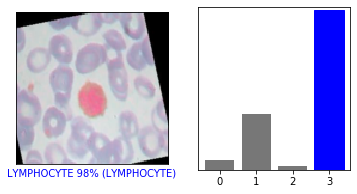

In [100]:
X_test1 = np.array(X_test).reshape(-1,128, 128, 3)
i = 1
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, prediction_single[i], y_test, X_test1)
plt.subplot(1,2,2)
plot_value_array(i, prediction_single[i],  y_test)
plt.show()

In [89]:
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array, true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(CATEGORIES[predicted_label],
                                100*np.max(predictions_array),
                                CATEGORIES[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array, true_label[i]
  plt.grid(False)
  plt.xticks(range(4))
  plt.yticks([])
  thisplot = plt.bar(range(4), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

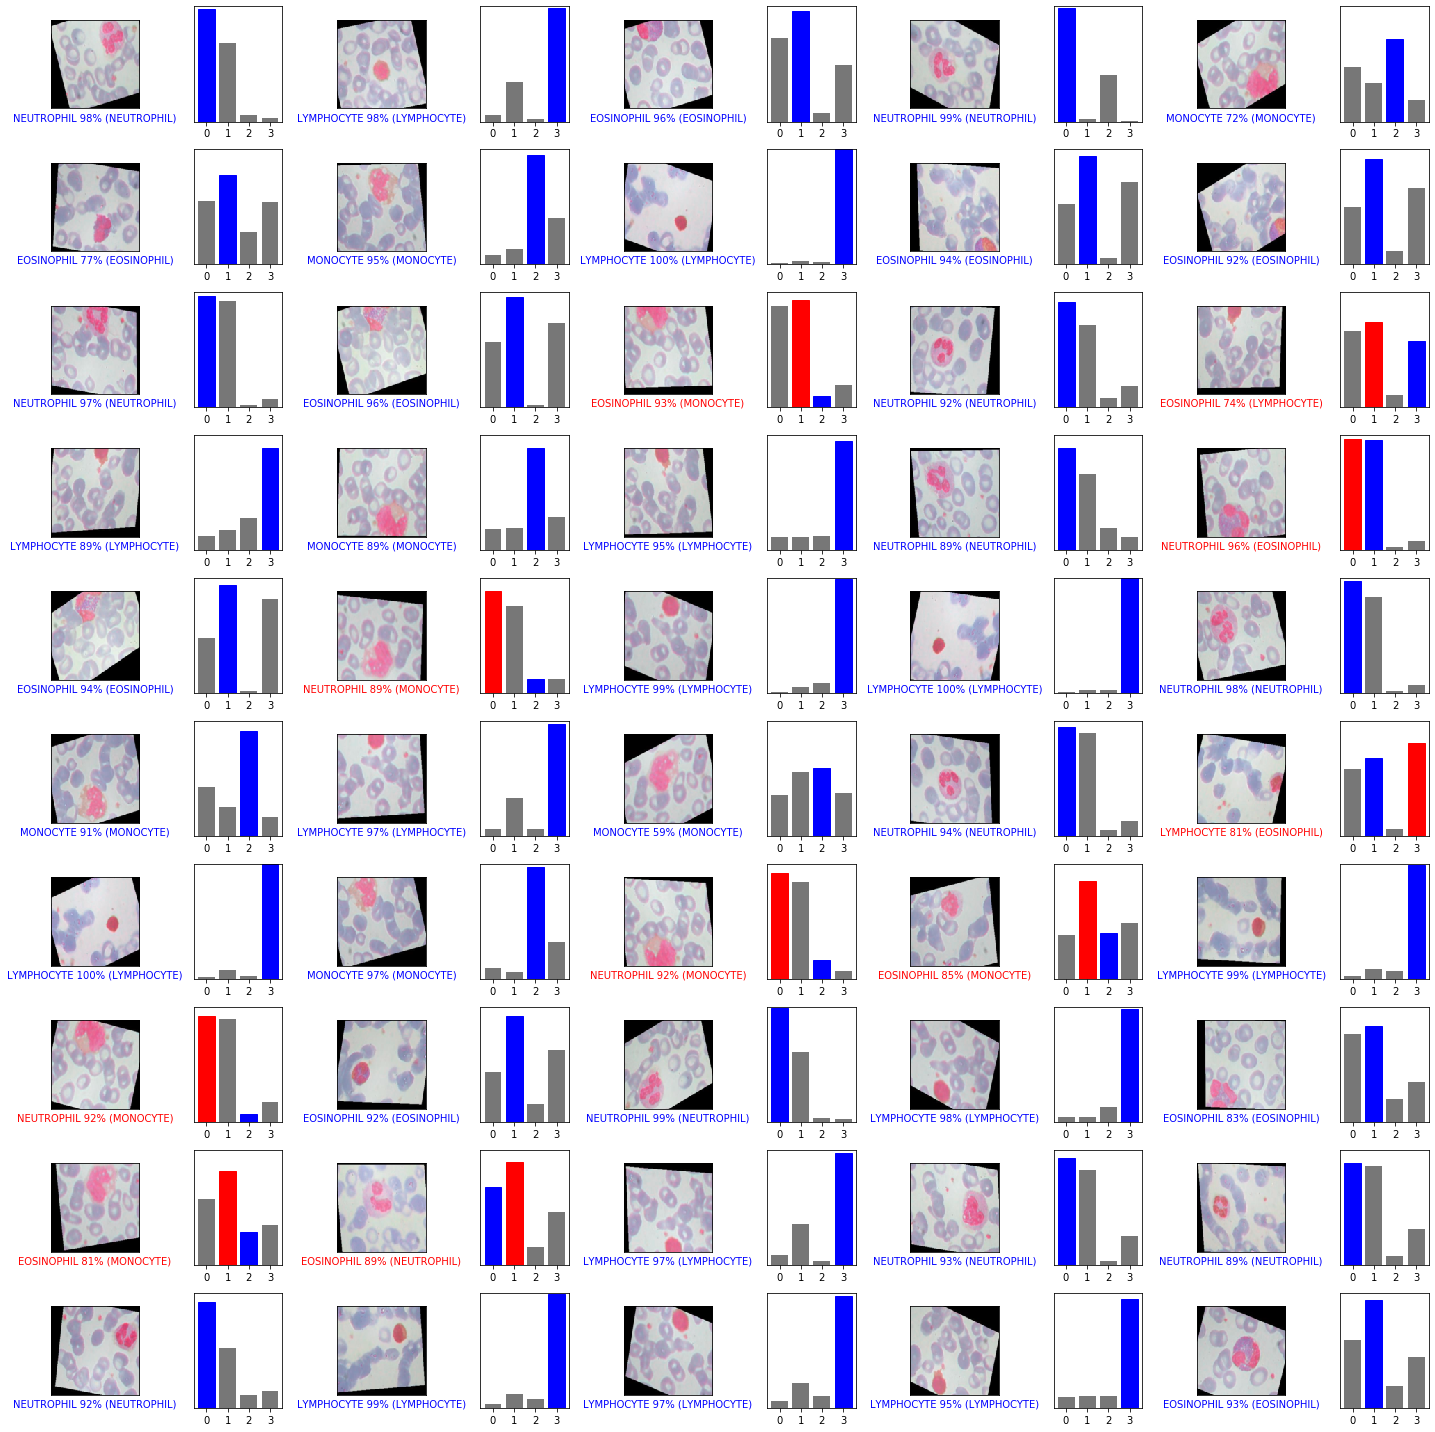

In [101]:
# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 10
num_cols = 5
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, prediction_single[i], y_test, X_test)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, prediction_single[i], y_test)
plt.tight_layout()
plt.show()

In [1]:
from sklearn.metrics import classification_report
from sklearn import metrics

print(metrics.confusion_matrix(y_test,pred_results ))


NameError: name 'y_test' is not defined

In [109]:
print(metrics.classification_report(y_test,pred_results, digits=4))

              precision    recall  f1-score   support

           0     0.6370    0.5849    0.6099       624
           1     0.5471    0.8106    0.6533       623
           2     0.9671    0.3790    0.5446       620
           3     0.8182    0.9871    0.8947       620

    accuracy                         0.6904      2487
   macro avg     0.7423    0.6904    0.6756      2487
weighted avg     0.7419    0.6904    0.6755      2487

